# Segmentation of Water Channels to Measure Water Contamination Due to Trash


In [7]:
from google.colab import drive
drive.mount('/content/drive')

import keras
from keras.models import Model
from keras.layers import Input,SeparableConv2D
from keras.layers import Activation, Reshape, Convolution2D, BatchNormalization
import os, sys
import numpy as np
import cv2
from keras.models import Model
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization,UpSampling2D,concatenate,Reshape
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
# from keras.utils import plot_model, to_categorical
import keras.backend as K
# from keras.utils import  to_categorical
import keras
from keras import optimizers
import tensorflow as tf
from sklearn.model_selection import train_test_split
# from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau, TensorBoard

# New libraries
from google.colab.patches import cv2_imshow
import random


Mounted at /content/drive


In [ ]:


Beta=[0.011676873, 0.869083715, 0.119239412]
Beta= np.array(Beta)
# print(Beta)
def convert_to_logits(y_pred):
      # see https://github.com/tensorflow/tensorflow/blob/r1.10/tensorflow/python/keras/backend.py#L3525
    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    return tf.math.log(y_pred / (1 - y_pred))

def blance_loss(y_true, y_pred):
    y_pred = convert_to_logits(y_pred)
    pos_weight =Beta
    loss = tf.nn.weighted_cross_entropy_with_logits(logits=y_pred, labels=y_true, pos_weight=pos_weight)

    # or reduce_sum and/or axis=-1
    return tf.reduce_mean(loss *(Beta))


#Model
inputs = Input((256,256,3))
conv1 = SeparableConv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = SeparableConv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = SeparableConv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = SeparableConv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = SeparableConv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = SeparableConv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = SeparableConv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = SeparableConv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
conv5 = SeparableConv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = SeparableConv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
drop5 = Dropout(0.5)(conv5)
up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
merge6 = concatenate([drop4,up6], axis = 3)
conv6 = SeparableConv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = SeparableConv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
merge7 = concatenate([conv3,up7], axis = 3)
conv7 = SeparableConv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = SeparableConv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = concatenate([conv2,up8], axis = 3)
conv8 = SeparableConv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = SeparableConv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = concatenate([conv1,up9], axis = 3)
conv9 = SeparableConv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = SeparableConv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = SeparableConv2D(3, 3, activation = 'softmax', padding = 'same', kernel_initializer = 'he_normal')(conv9)

model = Model(inputs,conv9)
model.compile(optimizer = Adam(lr = 1e-4), loss =blance_loss, metrics = ['accuracy'])


In [ ]:
model.load_weights('drive/My Drive/Colab Notebooks/model.h5')
#https://github.com/fezancs/Segmentation_detection-Model/blob/master/model.h5

#model file can be downloaded from given link



In [ ]:
def predict_(input_img):
    input_=np.array(cv2.imread(str(input_img)))
    input_ = cv2.resize(input_, (256,256), interpolation = cv2.INTER_NEAREST)
    input_=input_.reshape(1,256,256,3)
    input_=input_/255
    pre=model.predict(input_)
    pre=pre.reshape(256,256,3)
    pre=np.argmax(pre, axis=-1)
    label = keras.utils.to_categorical(pre,3)
    label[:,:,0]=label[:,:,1]
    label[:,:,2]=label[:,:,1]
    label=label*255
    cv2_imshow(label) # changed this as previous version did not work on Colab

In [ ]:
for i in range(0,10):
    image_dir = "drive/My Drive/Colab Notebooks/5000 Sementic Segmentation/new_x_/"+ str(random.randint(0, 5349)) + ".png"
    image = cv2.imread(image_dir)
    cv2_imshow(image)
    predict_(image_dir)

In [27]:
# Loading and pre-processing the data for use by U-net
height = 128
width = 128
classes = 3

# Train images (~90%)
train_new_x_ = []
train_new_y_ = []

# Test images (~10%)
test_new_x_ = []
test_new_y_ = []

# Path of the image data set
google_drive_path = 'drive/My Drive/Colab Notebooks/5000 Sementic Segmentation/'
image_directory = google_drive_path + 'new_x_/'
label_directory = google_drive_path + 'new_y_/'

# Num of training images
# 5349
num_of_train_img = int(0.9*(100))

# Num of test images
num_of_test_img = int(100 - num_of_train_img)

for name in range(0,num_of_train_img):
    imageFileName = image_directory + str(name+1) + ".png"
    # print(imageFileName)

    img = cv2.imread(imageFileName , cv2.IMREAD_COLOR)
    img = cv2.resize(img, (width,height))
    img = img / 255.0
    img = img.astype(np.float32)
    train_new_x_.append(img)

    # segmented image
    maskFileName = label_directory + str(name+1) + ".png"
    mask = cv2.imread(maskFileName , cv2.IMREAD_GRAYSCALE) # gray scale images
    mask = cv2.resize(mask , (width, height))
    train_new_y_.append(mask)


# Converting to numpy arrays
train_new_x_np = np.array(train_new_x_)
train_new_y_np = np.array(train_new_y_)
train_new_y_np = train_new_y_np.astype(int)


# Repeating the same process for test data
num_of_train_img+=1

for i in range(0,num_of_test_img):
    imageFileName = image_directory + str(num_of_train_img+i) + ".png"

    img = cv2.imread(imageFileName , cv2.IMREAD_COLOR)
    img = cv2.resize(img, (width,height))
    img = img / 255.0
    img = img.astype(np.float32)
    test_new_x_.append(img)

    # segmented image
    maskFileName = label_directory + str(num_of_train_img+i) + ".png"
    mask = cv2.imread(maskFileName , cv2.IMREAD_GRAYSCALE) # gray scale images
    mask = cv2.resize(mask , (width, height))
    test_new_y_.append(mask)

test_new_x_np = np.array(test_new_x_)
test_new_y_np = np.array(test_new_y_)
test_new_y_np = test_new_y_np.astype(int)


In [17]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# tf.random.set_seed(42)

# Define the UNet model architecture
def smaller_unet_model(input_shape, num_classes):
    inputs = Input(input_shape)

    # Contracting Path (Encoder)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = Conv2D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same')(conv4)

    # Expansive Path (Decoder)
    up5 = UpSampling2D(size=(2, 2))(conv4)
    up5 = Conv2D(128, 2, activation='relu', padding='same')(up5)
    merge5 = Concatenate()([conv3, up5])
    conv5 = Conv2D(128, 3, activation='relu', padding='same')(merge5)
    conv5 = Conv2D(128, 3, activation='relu', padding='same')(conv5)

    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = Conv2D(64, 2, activation='relu', padding='same')(up6)
    merge6 = Concatenate()([conv2, up6])
    conv6 = Conv2D(64, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(64, 3, activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = Conv2D(32, 2, activation='relu', padding='same')(up7)
    merge7 = Concatenate()([conv1, up7])
    conv7 = Conv2D(32, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(32, 3, activation='relu', padding='same')(conv7)

    outputs = Conv2D(num_classes, 1, activation='softmax')(conv7)

    model = Model(inputs=inputs, outputs=outputs)

    return model



# # Create and compile the UNet model
input_shape = (128, 128, 3)  # Define your input image shape
num_classes = 3  # Number of segmentation classes
model = smaller_unet_model(input_shape, num_classes)
model.summary()



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 128, 128, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_95 (Conv2D)             (None, 128, 128, 32  9248        ['conv2d_94[0][0]']              
                                )                                                           

print the type after the convert :
float32
float64
X_train , X_val , y_train , y_val --------->>>>  shapes :
(720, 128, 128, 3)
(720, 128, 128, 3)
(180, 128, 128, 3)
(180, 128, 128, 3)
Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_171 (Conv2D)         (None, 128, 128, 32)         896       ['input_11[0][0]']            
                                                                                                  
 conv2d_172 (Conv2D)         (None, 128, 128, 32)         9248      ['conv2d_171[0][0]']          
                                                                                                  
 max_p

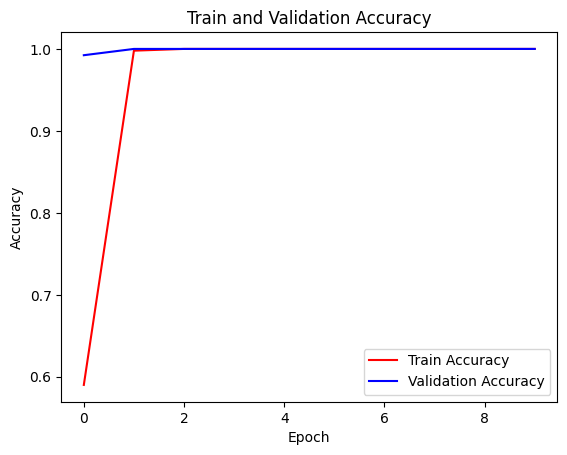

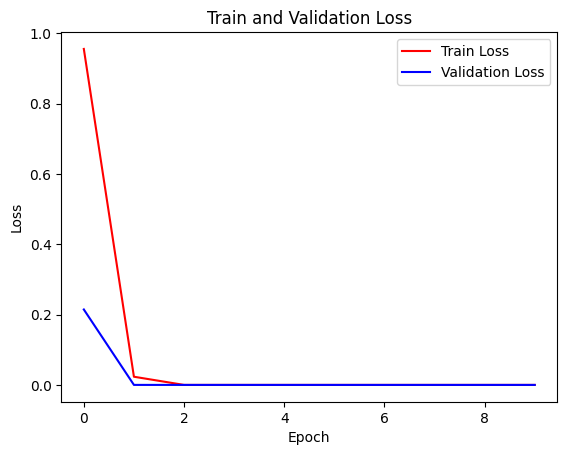

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Training the model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
# from keras.utils import np_utils


Weight = 128
Width = 128
numOfCategories = 3

train_new_y_np = train_new_y_np/255.0

maskForTheModel = tf.keras.utils.to_categorical(train_new_y_np , num_classes=numOfCategories)

print("print the type after the convert :")
print(maskForTheModel.dtype)
maskForTheModel = maskForTheModel.astype(float)
print(maskForTheModel.dtype)

X_train, X_val , y_train , y_val = train_test_split(train_new_x_np, maskForTheModel, test_size=0.2 , random_state=42)
print("X_train , X_val , y_train , y_val --------->>>>  shapes :")

print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)


# build the model
# from Step02UnetModel import build_unet

shape = (128,128,3)
num_classes = 3
lr = 1e-4 # 0.0001
batch_size = 32
epochs = 10


model = smaller_unet_model(shape , num_classes)
print(model.summary())

model.compile(loss="categorical_crossentropy", optimizer = tf.keras.optimizers.Adam(lr), metrics=['accuracy'])

stepsPerEpoch = np.ceil(len(X_train)/batch_size)
validationSteps = np.ceil(len(X_val)/batch_size)

best_model_file="drive/My Drive/Colab Notebooks/bestmodel.h5"

callbacks = [
    ModelCheckpoint(best_model_file, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.1, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor='val_loss',patience=5 , verbose=1)
]

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data = (X_val, y_val),
                    validation_steps = validationSteps,
                    steps_per_epoch = stepsPerEpoch,
                    shuffle=True,
                    callbacks=callbacks)


# show the results
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))


# train and validation Accuracy chart
plt.plot(epochs, acc , 'r', label="Train Accuracy")
plt.plot(epochs, val_acc, 'b' , label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Train and Validation Accuracy")
plt.legend(loc='lower right')
plt.show()

# train and validation loss chart
plt.plot(epochs, loss , 'r', label="Train Loss")
plt.plot(epochs, val_loss, 'b' , label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Train and Validation Loss")
plt.legend(loc='upper right')
plt.show()

In [29]:
def compute_mean_iou_per_class(y_true_list, y_pred_list, num_classes):
    mean_iou_per_class = [0] * num_classes

    for class_id in range(num_classes):
        iou_scores = []
        for y_true, y_pred in zip(y_true_list, y_pred_list):
            true_class = tf.equal(y_true, class_id)
            pred_class = tf.equal(y_pred, class_id)

            intersection = tf.reduce_sum(tf.cast(tf.logical_and(true_class, pred_class), dtype=tf.float32))
            union = tf.reduce_sum(tf.cast(tf.logical_or(true_class, pred_class), dtype=tf.float32))

            iou = intersection / (union + 1e-10)  # Adding a small epsilon to prevent division by zero
            iou_scores.append(iou)

        mean_iou_per_class[class_id] = np.mean(iou_scores)

    return mean_iou_per_class

In [30]:
# Testing the model
best_model_file="drive/My Drive/Colab Notebooks/bestmodel.h5"
model = tf.keras.models.load_model(best_model_file)
# print(model.summary())

Height = 128
Width= 128
NumOfCategories = 3

allTestImagesNP = test_new_x_np
maskTestImagesNP = test_new_y_np

maskImagesForModel = tf.keras.utils.to_categorical(allTestImagesNP,num_classes=NumOfCategories)
maskImagesForModel = maskImagesForModel.astype(float)


p_list = []
imgForModel_list = []
predicted_mask_list = []

for i in range(0,10):
    img = allTestImagesNP[i]
    imgForModel_list.append(np.expand_dims(img, axis=0))
    p_list.append(model.predict(imgForModel_list[i]))
    predicted_mask_list.append(np.argmax(p_list[i], axis=-1))


# Calculate the IoU score
iou_scores = compute_mean_iou_per_class(maskTestImagesNP, predicted_mask_list, NumOfCategories)
print("IoU Scores:",iou_scores)

for class_id, iou in enumerate(iou_scores):
    print(f"Class {class_id}: {iou:.2f}")
####################


1/1 [==============================] - 0s 80ms/step
IoU Scores: [0.90411985, 0.0, 0.0]
Class 0: 0.90
Class 1: 0.00
Class 2: 0.00


# Part C: Building a Similar Image Finder Web App with Streamlit

# Basic Architecure for similarity model

In [22]:
!npm install localtunnel
# pip install streamlit

npm WARN saveError ENOENT: no such file or directory, open '/content/package.json'
npm WARN enoent ENOENT: no such file or directory, open '/content/package.json'
npm WARN content No description
npm WARN content No repository field.
npm WARN content No README data
npm WARN content No license field.

+ localtunnel@2.0.2
updated 1 package and audited 36 packages in 0.502s

3 packages are looking for funding
  run `npm fund` for details

found 0 vulnerabilities



In [21]:
pip install streamlit

In [20]:
# Import necessary libraries
import streamlit as st
import pandas as pd
from PIL import Image
import io
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import requests
from pathlib import Path
import tensorflow as tf
import tensorflow_hub as hub

# Load a pre-trained model for feature extraction (InceptionV3 in this case)
feature_extraction_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = tf.keras.Model(inputs=feature_extraction_model.input, outputs=feature_extraction_model.layers[-1].output)

In [15]:
# # Part C: Building a Similar Image Finder Web App with Streamlit
import streamlit as st
import pandas as pd
from PIL import Image
import pickle
import io
import requests
from pathlib import Path
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Part 3: Backend Implementation
# Implement your image similarity calculation logic here

def download_images(image_urls, output_folder):
    output_folder = Path(output_folder)

    if not output_folder.exists():
        output_folder.mkdir()

    for index, image_url in enumerate(image_urls):
        response = requests.get(image_url)
        if response.status_code == 200:
            with open(output_folder / f"image_{index}.jpg", "wb") as f:
                f.write(response.content)

def extract_features(image):
    image = image.resize((224, 224))
    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    features = feature_extractor(image)
    return features.numpy().flatten()

def extract_features_from_images(image_folder):
    image_features_list = list()
    for image_path in Path(image_folder).glob("*.jpg"):
        image = Image.open(image_path)
        try:
            features = extract_features(image)
            image_features_list.append(features)
        except:
            pass
    dataset_features = np.array(image_features_list)
    return dataset_features

def find_similar_images(query_features, dataset_features, top_n=5):
    similarities = cosine_similarity(query_features.reshape(1, -1), dataset_features)
    similar_indices = np.argsort(similarities, axis=1)[0, -top_n:][::-1]
    return similar_indices

df = pd.read_csv('drive/My Drive/Colab Notebooks/Data ID - Sheet1.csv')
image_urls = df['image_link']

image_folder = "downloaded_images"
download_images(image_urls, image_folder)

dataset_images_paths = list(Path(image_folder).glob("*.jpg"))


dataset_features = extract_features_from_images(image_folder)

pickle_filename = "dataset_features.pickle"


with open(pickle_filename, 'wb') as pickle_file:
    pickle.dump(dataset_features, pickle_file)

st.write(f"Saved dataset_features to {pickle_filename}")


2023-10-15 12:08:18.868 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py [ARGUMENTS]


In [24]:
# Part 9: Submission
# Extract features from the dataset images
%%writefile napp.py
import streamlit as st
import streamlit as st
import pandas as pd
from PIL import Image
import io
import pickle
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import requests
from pathlib import Path
import tensorflow as tf
import tensorflow_hub as hub


# Part 4: Frontend Web App
# Create a Streamlit app

with open('dataset_features.pickle', 'rb') as pickle_file:
     dataset_features = pickle.load(pickle_file)
with open('dataset_images_paths', 'rb') as pickle_file:
     dataset_images_paths = pickle.load(pickle_file)
feature_extraction_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = tf.keras.Model(inputs=feature_extraction_model.input, outputs=feature_extraction_model.layers[-1].output)

def extract_features(image):
    image = image.resize((224, 224))
    image = np.array(image) / 255.0  # Normalize pixel values
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    features = feature_extractor(image)
    return features.numpy().flatten()

# Function to extract features from all images in a folder and store in a dictionary
def extract_features_from_images(image_folder):
    image_features_dict = {}
    for image_path in Path(image_folder).glob("*.jpg"):
        image = Image.open(image_path)
        try:
          features = extract_features(image)
        except:
          pass
        image_features_dict[str(image_path)] = features
    return image_features_dict

# Function to find similar images based on features
def find_similar_images(query_features, dataset_features, top_n=5):
    similarities = cosine_similarity(query_features.reshape(1, -1), dataset_features)
    similar_indices = np.argsort(similarities, axis=1)[0, -top_n:][::-1]
    return similar_indices

def main():
    st.title("Image Similarity Finder")

    # Part 10: Explain the structure and layout of your Streamlit app

    # Part 11: Provide instructions to users
    st.sidebar.header("Instructions")
    st.sidebar.markdown("1. Upload an image.")
    st.sidebar.markdown("2. Click the 'Find Similar Images' button.")

    # Upload image
    uploaded_image = st.file_uploader("Upload an image", type=["jpg", "jpeg", "png"])

    if uploaded_image:
        # Display the uploaded image
        st.image(uploaded_image, caption="Uploaded Image", use_column_width=True)

        # Perform image similarity search
        if st.button("Find Similar Images"):
            # st.button("Find Similar Images"):
            # Read and preprocess the query image
            query_image = Image.open(uploaded_image)

            # Extract features from the query image
            query_features = extract_features(query_image)


            # Call your image similarity search function here
            similar_indices = find_similar_images(query_features, dataset_features, top_n=5)

            # Display results below
            st.subheader("Similar Images:")
            for index in similar_indices:
                st.image(Image.open(dataset_images_paths[index]), caption=f"Similar Image {index}", use_column_width=True)



    # Part 18: User Interface Design
    # Explain design choices here

    # Part 19: Include screenshots of your web app
    st.sidebar.header("Screenshots")
    # Add screenshots here

if __name__ == "__main__":
    main()

# main()

Overwriting napp.py


In [ ]:
import urllib
print("Password/Enpoint IP for localtunnel is:",urllib.request.urlopen('https://ipv4.icanhazip.com').read().decode('utf8').strip("\n"))

In [26]:
!streamlit run napp.py &>/content/logs.txt &
!npx localtunnel --port 8501

npx: installed 22 in 2.776s
your url is: https://heavy-bats-shout.loca.lt
^C
